# Inital imports

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)

# Hyper-Parameters for training

In [2]:
BATCH_SIZE = 32

# Check versions of crucial libraries

In [3]:
print(torch.__version__)
print(torchvision.__version__)
print(PIL.__version__)


1.3.1
0.4.2
6.2.1


# Data augmentation Functions

The following classes define different augmentation approaches.


# Imgaug-Augmentation

In [4]:
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa

class ImgAugTransform:
    def __init__(self):
        # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
        # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
        sometimes = lambda t: iaa.Sometimes(0.5, t)


        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug = iaa.Sequential(
            [
                iaa.OneOf([
                    # apply the following augmenters to most images
                    iaa.Fliplr(0.5), # horizontally flip 50% of all images
                    #iaa.Flipud(0.2), # vertically flip 20% of all images

                    iaa.Sometimes(0.33, iaa.GaussianBlur(sigma=(0, 3.0))),
                    iaa.Sometimes(0.33, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
                    iaa.Sometimes(0.33, iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)),
                ]),
                # apply the following augmenters to most images
                iaa.Fliplr(0.5), # horizontally flip 50% of all images
                #iaa.Flipud(0.2), # vertically flip 20% of all images
                
                iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),
                iaa.Sometimes(0.2, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
                iaa.Sometimes(0.2, iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)),
                iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        
                
                #crop images by -5% to 10% of their height/width
                sometimes(iaa.CropAndPad(
                    percent=(-0.05, 0.1),
                    pad_mode=ia.ALL,
                    pad_cval=(0, 255)
                )),
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-16, 16), # shear by -16 to +16 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges,
                        # blend the result with the original image using a blobby mask
                        iaa.SimplexNoiseAlpha(iaa.OneOf([
                            iaa.EdgeDetect(alpha=(0.5, 1.0)),
                            iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                        ])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                        # either change the brightness of the whole image (sometimes
                        # per channel) or change the brightness of subareas
                        iaa.OneOf([
                            iaa.Multiply((0.5, 1.5), per_channel=0.5),
                            iaa.FrequencyNoiseAlpha(
                                exponent=(-4, 0),
                                first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                second=iaa.LinearContrast((0.5, 2.0))
                            )
                        ]),
                        iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        iaa.Grayscale(alpha=(0.0, 1.0)),
                        sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

transform_imgaug = ImgAugTransform()


# Pytorch-Augmentation 

In [5]:
import PIL

transform_pytorch = torchvision.transforms.Compose([
    #torchvision.transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomResizedCrop(32),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(90, resample=PIL.Image.BILINEAR),
])

# Albumentations

# AutoAugment

rom AutoAugment.autoaugment import CIFAR10Policy
#from autoaugment import CIFAR10Policy
transform_autoaugment =transforms.Compose([
                         #transforms.RandomCrop(32, padding=4, fill=128), # fill parameter needs torchvision installed from source
                         #transforms.RandomHorizontalFlip(),
                         CIFAR10Policy(),  
                         #Cutout(n_holes=1, length=16), # (https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py)
                         ])

In [6]:
from pytorchAutoAugment.auto_augment import AutoAugment
from pytorchAutoAugment.auto_augment import Cutout

transform_autoaugment = transforms.Compose([
    AutoAugment(),
    #Cutout(),
])


# Split in test and training set with applying of transforms

In [18]:
#The compose function allows for multiple transforms
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
#transforms.Normalize(mean,std) normalizes a tensor to a (mean, std) for (R, G, B)

transform_tensor_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_imgaug_norm = transforms.Compose([transform_imgaug, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_pytorch_norm = transforms.Compose([transform_pytorch, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#transform_albumentations_norm = transforms.Compose([transform_albumentations, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_autoaugment_norm = transforms.Compose([transform_autoaugment, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_set_norm = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_tensor_norm)
train_set_imgaug = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_imgaug_norm)
train_set_pytorch = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_pytorch_norm)
#train_set_albumentations = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_albumentations_norm)
train_set_autoaugment = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_autoaugment_norm)


test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=True, transform=transform_tensor_norm)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
len(train_set_norm)

50000

# Concat datasets

In [9]:
#dataset_norm = train_set_norm + train_set_norm
dataset_norm = train_set_norm

dataset_imgaug = torch.utils.data.ConcatDataset((train_set_norm, train_set_imgaug))

dataset_pytorch = torch.utils.data.ConcatDataset((train_set_norm, train_set_pytorch))

dataset_autoaugment = torch.utils.data.ConcatDataset((train_set_norm, train_set_autoaugment))


#dataset_albumentations = torch.utils.data.ConcatDataset((train_set_norm, train_set_albumentations))

#dataset_imgaug = train_set_norm + train_set_imgaug
#dataset_pytorch = train_set_norm + train_set_pytorch
#dataset_autoaugment = train_set_norm + train_set_autoaugment

In [10]:
print(len(dataset_norm))
print(len(dataset_imgaug))
print(len(dataset_pytorch))
print(len(dataset_autoaugment))

#print(dataset_imgaug.cumulative_sizes)
#print(dataset_pytorch.cumulative_sizes)
#print(dataset_autoaugment.cumulative_sizes)
#print(dataset_albumentations.cumulative_sizes)

50000
100000
100000
100000


In [20]:
#trainsets = {'norm' : dataset_norm, 'imgaug' : dataset_imgaug, 'pytorch' : dataset_pytorch, 'autoaugment' : dataset_autoaugment, 'albumentations' : dataset_albumentations}
#trainsets = {'norm' : dataset_norm, 'imgaug' : dataset_imgaug, 'pytorch' : dataset_pytorch, 'autoaugment' : dataset_autoaugment}
trainsets = {'norm' : train_set_norm, 'imgaug' : train_set_imgaug, 'pytorch' : train_set_pytorch, 'autoaugment' : train_set_autoaugment}
#trainsets = {'autoaugment' : dataset_autoaugment}


In [12]:
#Training
n_training_samples = 20000
train_sampler = torch.utils.data.SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

In [13]:


#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size, train_set):
    
    #Training
    #n_training_samples = 50000 # Number of training samples
    #train_sampler = torch.utils.data.RandomSampler(train_set, replacement=False, num_samples=n_training_samples)
    #train_sampler = torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=n_training_samples)
    
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=0)

    
    return(train_loader)

# Preprocess the data with augmentation.
To spare the augmentation from being applied on every loading during training, preprocessing is done once.
With this, the random effect of some augmentation is gone to a static one though.

In [14]:
parent_dir = './preprocessed_data'

PREPROCESS = False

if PREPROCESS:
    import os

    for key in trainsets:

        #Use the data loader to only load the subset of specified images
        train_loader = get_train_loader(BATCH_SIZE, trainsets[key])

        dirName = key

        try:
            # Create target Directory
            os.mkdir(parent_dir + '/' + dirName)
            print("Directory " , dirName ,  " Created ") 
        except FileExistsError:
            print("Directory " , dirName ,  " already exists")

        #Save the dataset batch-wise
        for idx, data in enumerate(train_loader, 0):
            torch.save(data, '{}/{}/{}'.format(parent_dir, key, idx))

    
    

# Check the augmentation data sets by taking some sample plots

In [16]:

import matplotlib as mpl
import matplotlib.pyplot as plt
def plotSomeImages(n, dataiter, title):


    n_plots = n
    
    fig=plt.figure(figsize=(12, 10), dpi=80)

    for i in range(n_plots):
        
        
        images, labels = dataiter.next()

        img = images[0]
        img = img / 2 + 0.5     # unnormalize

        fig.add_subplot(4,4,i+1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))


    fig.suptitle(title, fontsize=16)
    plt.show()

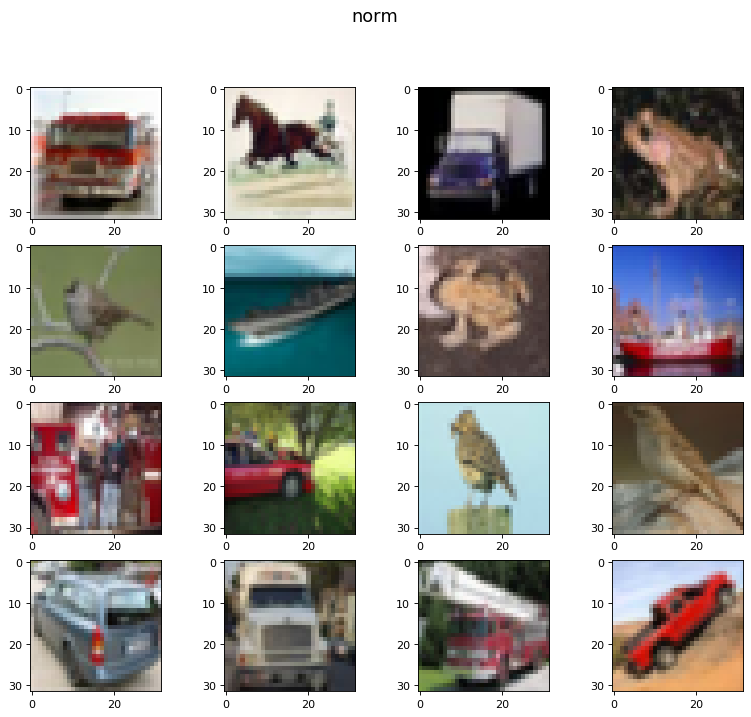

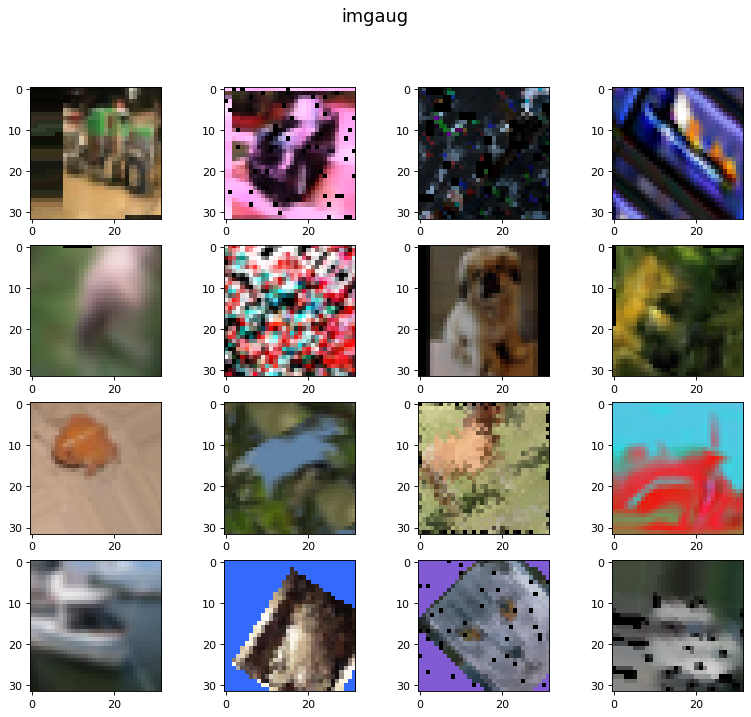

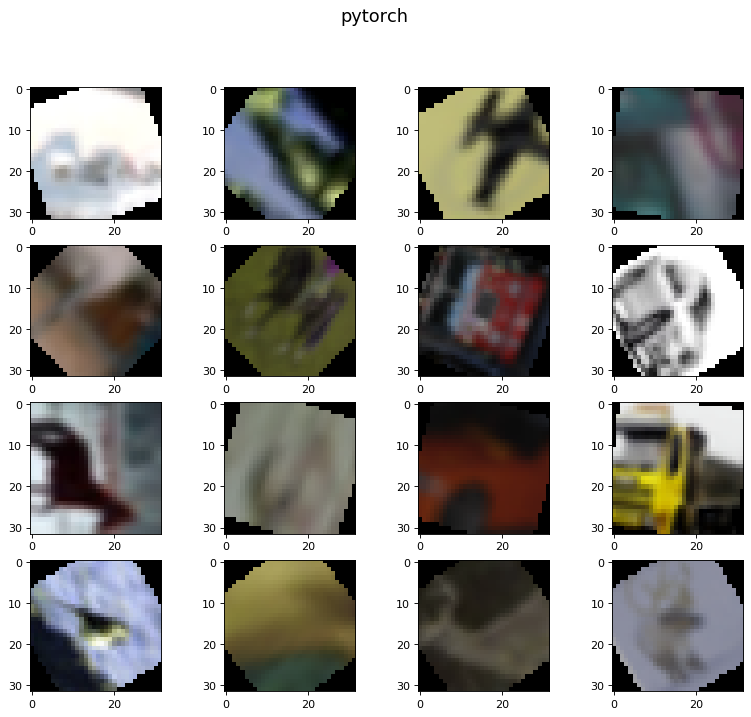

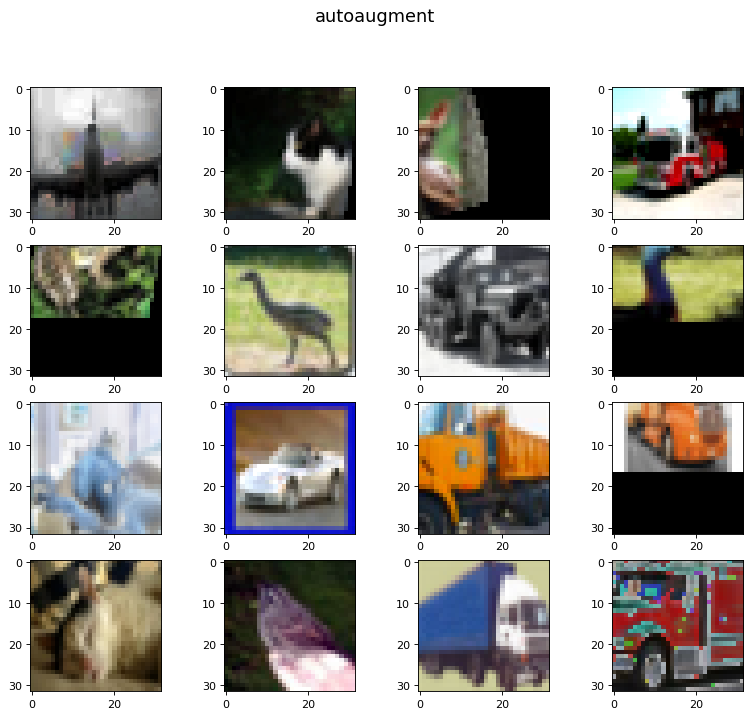

In [21]:
#trainsets = {'norm' : dataset_norm, 'imgaug' : train_set_imgaug, 'pytorch' : train_set_pytorch, 'autoaugment' : train_set_autoaugment}
#trainsets = {'albumentations' : train_set_albumentations}

n=16

for key in trainsets:
    #print("Augmentation: " + key)
    loader = get_train_loader(1, trainsets[key])
    dataiter = iter(loader)
    plotSomeImages(n, dataiter, key)

# Train the same model with different augmentations

# Results compared

[ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]


# TODO:

# Fragen